## Import Libraries

In [1]:
%matplotlib inline

# General libraries.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn import preprocessing
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Using TensorFlow backend.


## Define Methods

In [75]:
NUM_PCA_COMPONENTS = 20

def test_model_accuracy(model, train_features, train_labels, test_features, test_labels):
    
    #le = LabelEncoder()
    #train_labels_encoded = le.fit_transform(train_labels)
    #test_labels_encoded = le.transform(test_labels)
    #print(test_labels_encoded)
    
    # Fit model
    model.fit(train_features, train_labels)
    
    # Predict
    y_predict = model.predict(test_features)
        
    # Get accuracy
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    
    return accuracy, f1

def test_cluster_accuracy(model, train_features, test_features):
    
    train_labels = model.fit(train_features).predict(train_features)
    model.fit(train_features)
        
    # Predict using k = k_value
    y_predict = model.predict(test_features)
    
    test_labels =  model.fit(test_features).predict(test_features)
        
    # Get accuracy for each k_value
    cvs = np.mean(cross_val_score(model, test_features, test_labels, cv=5))
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    return accuracy, f1, cvs

def plot_scores(param_list, score1_list, score2_list, param_name, score1_name, score2_name, model_name, is_id):
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score1_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score1_name)
    
    if True == is_id:
        ax.set_ylim(0,40)
    else:
        ax.set_ylim(0,100)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score1_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score2_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score2_name)
    
    if True == is_id:
        ax.set_ylim(0,0.35)
    else:
        ax.set_ylim(0,1)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score2_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
def plot_score(param_list, score1_list, param_name, score1_name, model_name):
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score1_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score1_name)
    
    ax.set_ylim(0,1)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score1_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
def print_best_parameters(param_list, id_acc_list, id_f1_list, species_acc_list, species_f1_list, species_cv_list):
    print("ID Prediction:")
    print("Best Accuracy: " + str(max(id_acc_list)))
    print("Best Accuracy Parameter: " + str(param_list[np.where(id_acc_list == np.amax(id_acc_list))[0][0]]), end="\n\n")
    print("Best F1 Score : " + str(max(id_f1_list)))
    print("Best F1 Score  Parameter: " + str(param_list[np.where(id_f1_list == np.amax(id_f1_list))[0][0]]), end="\n\n\n")
    
    print("Species Prediction:")
    print("Best Accuracy: " + str(max(species_acc_list)))
    print("Best Accuracy Parameter: " + str(param_list[np.where(species_acc_list == np.amax(species_acc_list))[0][0]]), end="\n\n")
    print("Best F1 Score : " + str(max(species_f1_list)))
    print("Best F1 Score : " + str(param_list[np.where(species_f1_list == np.amax(species_f1_list))[0][0]]), end="\n\n")
    print("Best Cross Validation Score: " + str(max(species_cv_list)))
    print("Best Cross Validation Parameter: " + str(param_list[np.where(species_cv_list == np.amax(species_cv_list))[0][0]]), end="\n\n\n")

## Load Processed Sample Data

df = pd.read_csv("processed_batch_df_individuals_over_5_pics.csv")

df.head()

# Examine the Sample Data
df.shape

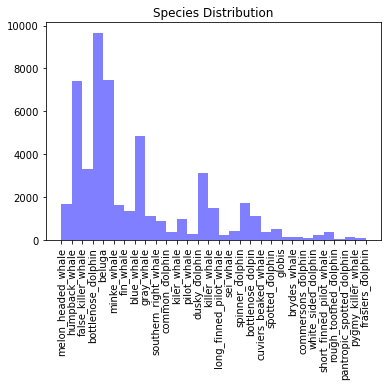

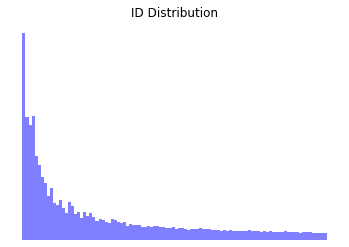

In [3]:
train_labels_df = pd.read_csv("train.csv")

plt.title("Species Distribution")
plt.hist(train_labels_df['species'], train_labels_df['species'].unique(), facecolor='blue', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

plt.title("ID Distribution")
plt.hist(train_labels_df['individual_id'], bins=100, facecolor='blue', alpha=0.5)
plt.xticks(rotation=90)
plt.axis('off')
plt.show()

## Split Training and Test Data
### For every five samples for an individual (same ID), one sample is for testing while the other four are for training

df_arr = np.array(df)

training_data_dict = dict()
testing_data_dict = dict()

# Initialize columns
for col in tqdm(df.columns):
    training_data_dict[col] = list()
    testing_data_dict[col] = list()

temp_id = ""
    
for i in tqdm(range(df.shape[0])):
    curr_id = df_arr[i][3]
    
    if temp_id != curr_id:
        # Different ID, add to testing_data
        j = 0
        for col in df.columns:
            testing_data_dict[col].append(df_arr[i][j])
            j = j+1
        
        temp_id = curr_id
    else:
        # Same ID, add to training_data
        j = 0
        for col in df.columns:
            training_data_dict[col].append(df_arr[i][j])
            j = j+1
        
# Release memory of df_arr
df_arr = None  
    
training_data = pd.DataFrame(training_data_dict)
testing_data = pd.DataFrame(testing_data_dict)

training_data.to_csv('train_data.csv')
testing_data.to_csv('test_data.csv')

## Divide the Training and Test Data Into Features, Species Labels, and IDs

# Divide into features, ids, and species
test_features = testing_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
test_labels = testing_data['species']
test_ids = testing_data['individual_id']

test_labels.to_csv('test_labels.csv')
test_features.to_csv('test_features.csv')
test_ids.to_csv('test_ids.csv')

train_features = training_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
train_labels = training_data['species']
train_ids = training_data['individual_id']

train_labels.to_csv('train_labels.csv')
train_features.to_csv('train_features.csv')
train_ids.to_csv('train_ids.csv')

## Load the Data
### This is called first durting testing to avoid repetitive processing of the original data

In [4]:
# Load saved split data
test_labels = pd.read_csv("test_labels.csv")
test_features = pd.read_csv("test_features.csv")
test_ids = pd.read_csv("test_ids.csv")

train_labels = pd.read_csv("train_labels.csv")
train_features = pd.read_csv("train_features.csv")
train_ids = pd.read_csv("train_ids.csv")

In [5]:
# Remove 'Unnamed: 0' columns
test_labels.drop('Unnamed: 0', inplace=True, axis=1)
test_features.drop('Unnamed: 0', inplace=True, axis=1)
test_ids.drop('Unnamed: 0', inplace=True, axis=1)

train_labels.drop('Unnamed: 0', inplace=True, axis=1)
train_features.drop('Unnamed: 0', inplace=True, axis=1)
train_ids.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
# Convert to arrays
test_labels = np.array(test_labels).ravel()
test_features = np.array(test_features)
test_ids = np.array(test_ids).ravel()

train_labels = np.array(train_labels).ravel()
train_features = np.array(train_features)
train_ids = np.array(train_ids).ravel()

## Run PCA on the  Feature Data

In [7]:
scaler = StandardScaler()
train_features_std = scaler.fit_transform(train_features)
test_features_std = scaler.transform(test_features)

sklearn_pca = sklearnPCA(n_components=NUM_PCA_COMPONENTS)
train_features_pca = sklearn_pca.fit_transform(train_features_std)
test_features_pca = sklearn_pca.transform(test_features_std)

In [8]:
print(train_features_pca.shape)
print(test_features_pca.shape)

(5400, 20)
(1350, 20)


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


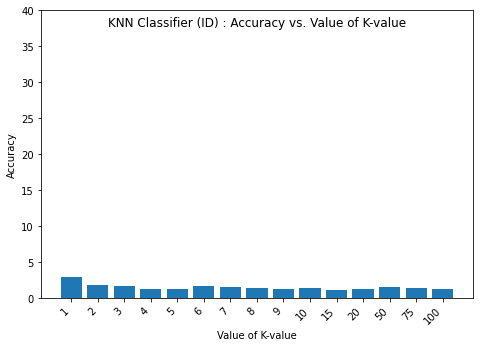

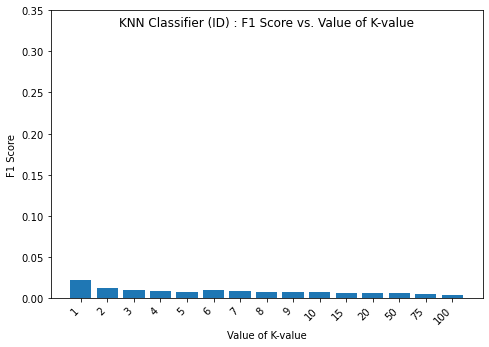

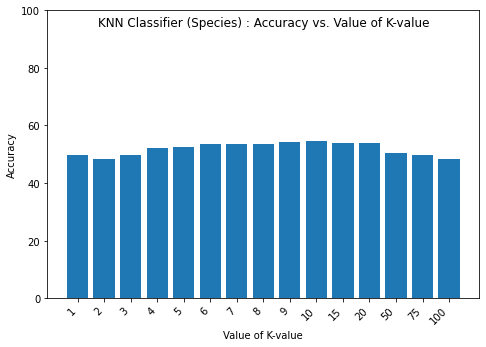

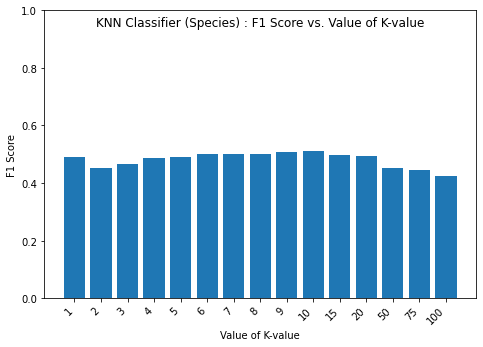

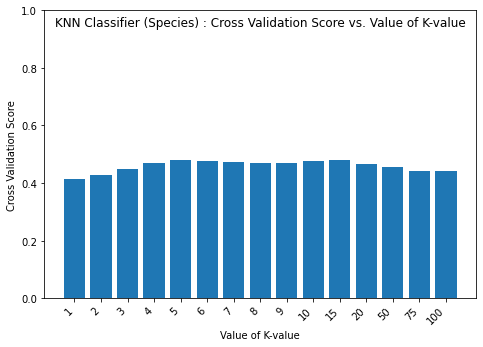

In [62]:
#  K-Nearest Neighbors model
knnmodel = KNeighborsClassifier(n_neighbors=1)

k_values = [1,2,3,4,5,6,7,8,9,10,15,20,50,75,100]
knn_acc = list()
knn_f1_list = list()
knn_species_acc = list()
knn_species_f1_list = list()
knn_species_cvs_list = list()

for i in tqdm(range(len(k_values))):
    knnmodel = KNeighborsClassifier(n_neighbors=k_values[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    #print(np.mean(cross_val_score(knnmodel, test_features_pca, test_ids, cv=5))*100)
    knn_f1_list.append(f1)
    knn_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    knn_species_cvs_list.append(np.mean(cross_val_score(knnmodel, test_features_pca, test_labels, cv=5)))
    knn_species_f1_list.append(f1)
    knn_species_acc.append(ac)


plot_scores(k_values, knn_acc, knn_f1_list, "K-value", "Accuracy", "F1 Score", "KNN Classifier (ID)", True)
plot_scores(k_values, knn_species_acc, knn_species_f1_list, "K-value", "Accuracy", "F1 Score", "KNN Classifier (Species)", False)
plot_score(k_values, knn_species_cvs_list, "K-value", "Cross Validation Score", "KNN Classifier (Species)")

In [63]:
print_best_parameters(k_values, knn_acc, knn_f1_list, knn_species_acc, knn_species_f1_list, knn_species_cvs_list)

ID Prediction:
Best Accuracy: 2.888888888888889
Best Accuracy Parameter: 1

Best F1 Score : 0.022444444444444444
Best F1 Score  Parameter: 1


Species Prediction:
Best Accuracy: 54.592592592592595
Best Accuracy Parameter: 10

Best F1 Score : 0.5104307756634169
Best F1 Score : 10

Best Cross Validation Score: 0.48
Best Cross Validation Parameter: 5




100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


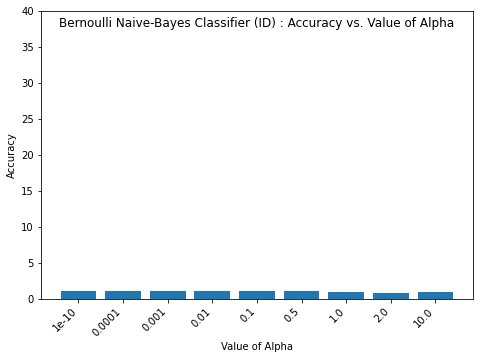

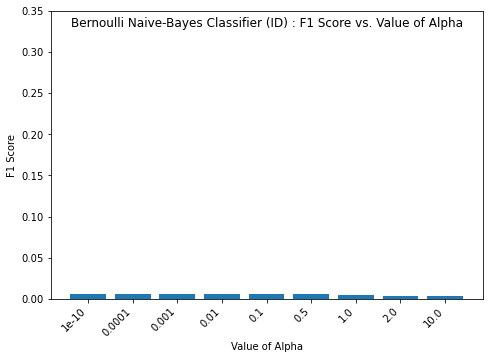

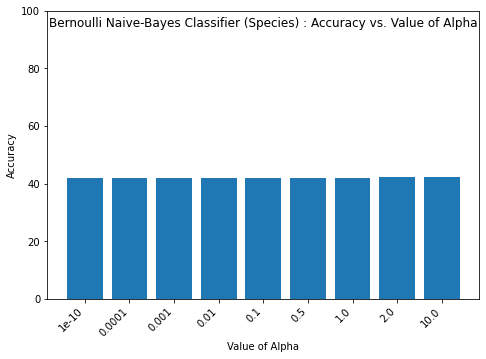

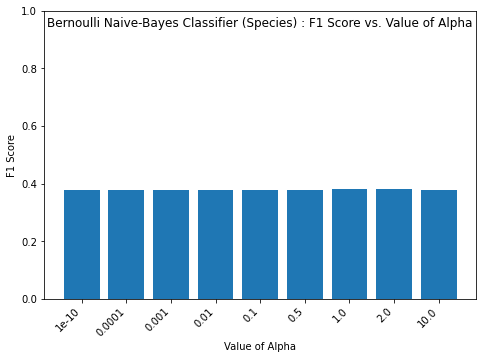

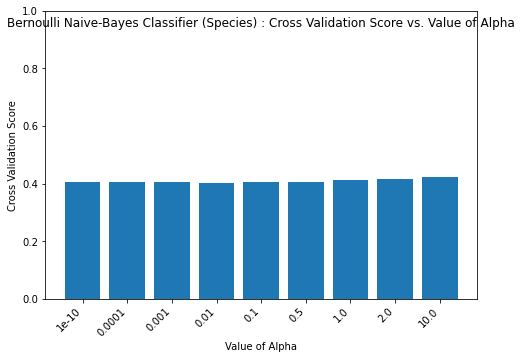

In [66]:
# Bernoulli Naive-Bayes
alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
nb_acc = list()
nb_f1_list = list()
nb_species_acc = list()
nb_species_f1_list = list()
nb_species_cvs_list = list()

for i in tqdm(range(len(alpha_list))):
    nbmodel = BernoulliNB(alpha=alpha_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    nb_f1_list.append(f1)
    nb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    nb_species_cvs_list.append(np.mean(cross_val_score(nbmodel, test_features_pca, test_labels, cv=5)))
    nb_species_f1_list.append(f1)
    nb_species_acc.append(ac)

plot_scores(alpha_list, nb_acc, nb_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (ID)", True)
plot_scores(alpha_list, nb_species_acc, nb_species_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (Species)", False)
plot_score(alpha_list, nb_species_cvs_list, "Alpha", "Cross Validation Score", "Bernoulli Naive-Bayes Classifier (Species)")

In [65]:
print_best_parameters(alpha_list, nb_acc, nb_f1_list, nb_species_acc, nb_species_f1_list, nb_species_cvs_list)

ID Prediction:
Best Accuracy: 1.037037037037037
Best Accuracy Parameter: 1e-10

Best F1 Score : 0.005742504409171075
Best F1 Score  Parameter: 1e-10


Species Prediction:
Best Accuracy: 42.2962962962963
Best Accuracy Parameter: 10.0

Best F1 Score : 0.38132383780172435
Best F1 Score : 2.0

Best Cross Validation Score: 0.4222222222222222
Best Cross Validation Parameter: 10.0




100%|██████████| 7/7 [01:10<00:00, 10.07s/it]


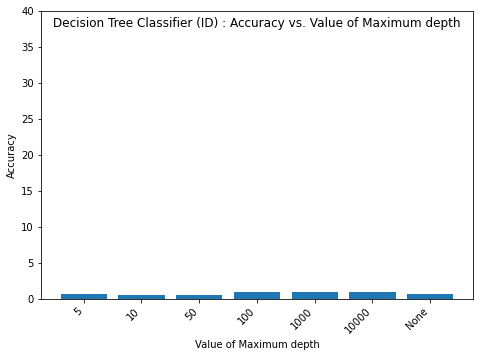

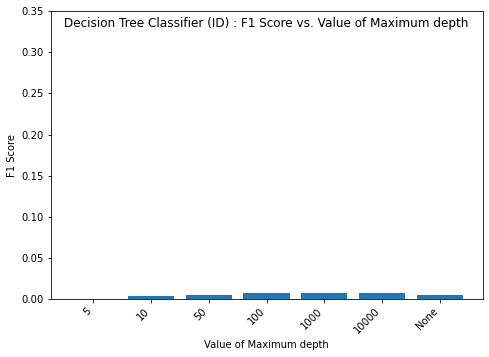

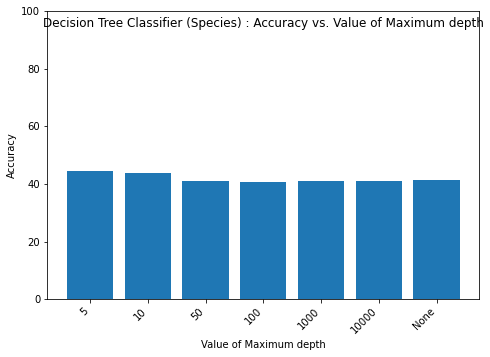

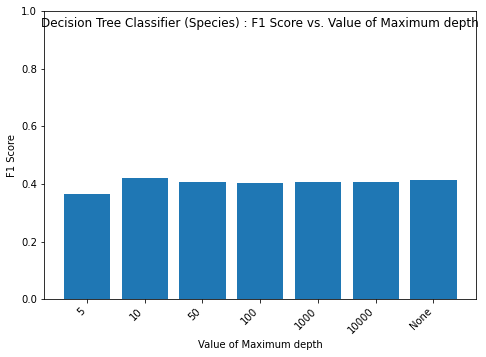

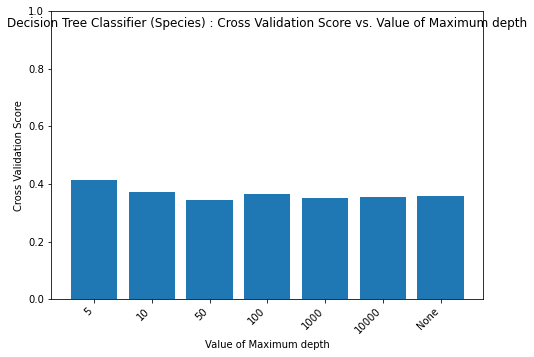

In [67]:
# Decision tree
max_depth_list = [5, 10, 50, 100, 1000, 10000, None]
dt_acc = list()
dt_f1_list = list()
dt_species_acc = list()
dt_species_f1_list = list()
dt_species_cvs_list = list()
    
for i in tqdm(range(len(max_depth_list))):
    dt = DecisionTreeClassifier(max_depth=max_depth_list[i], criterion='entropy')
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        dt,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    dt_f1_list.append(f1)
    dt_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        dt,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    dt_species_cvs_list.append(np.mean(cross_val_score(dt, test_features_pca, test_labels, cv=5)))
    dt_species_f1_list.append(f1)
    dt_species_acc.append(ac)


plot_scores(max_depth_list, dt_acc, dt_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (ID)", True)
plot_scores(max_depth_list, dt_species_acc, dt_species_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (Species)", False)
plot_score(max_depth_list, dt_species_cvs_list, "Maximum depth", "Cross Validation Score", "Decision Tree Classifier (Species)")

In [68]:
print_best_parameters(max_depth_list, dt_acc, dt_f1_list, dt_species_acc, dt_species_f1_list, dt_species_cvs_list)

ID Prediction:
Best Accuracy: 1.037037037037037
Best Accuracy Parameter: 1000

Best F1 Score : 0.008074074074074074
Best F1 Score  Parameter: 10000


Species Prediction:
Best Accuracy: 44.44444444444444
Best Accuracy Parameter: 5

Best F1 Score : 0.42240885794819194
Best F1 Score : 10

Best Cross Validation Score: 0.4133333333333333
Best Cross Validation Parameter: 5




100%|██████████| 7/7 [01:28<00:00, 12.69s/it]


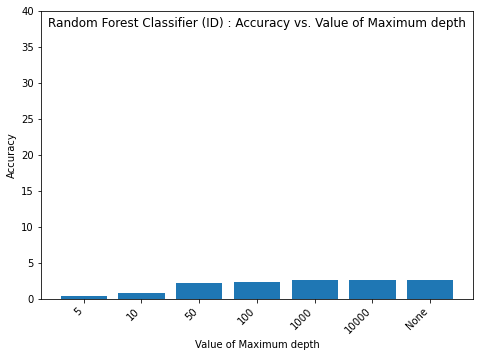

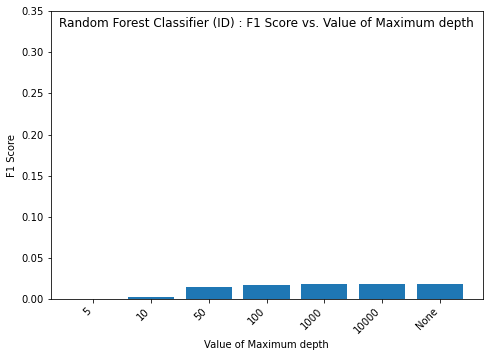

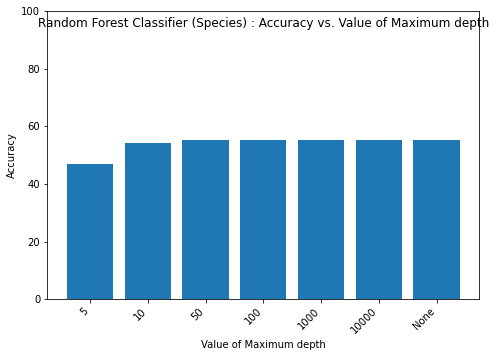

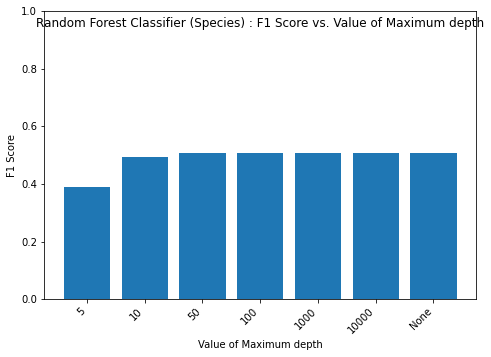

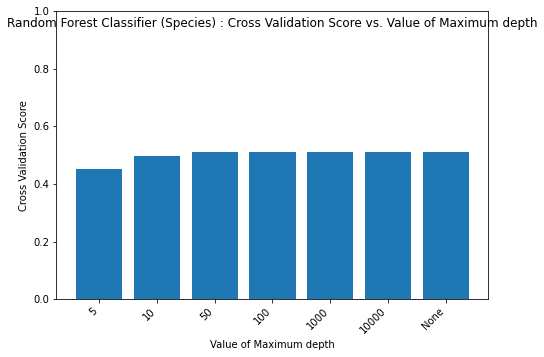

In [69]:
# Random Forest
max_depth_list = [5, 10, 50, 100, 1000, 10000, None]
rf_acc = list()
rf_f1_list = list()
rf_species_acc = list()
rf_species_f1_list = list()
rf_species_cvs_list = list()
    
for i in tqdm(range(len(max_depth_list))):
    rf_dt = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=max_depth_list[i],
                                       n_estimators=100, oob_score=True)
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        rf_dt,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    rf_f1_list.append(f1)
    rf_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        rf_dt,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    rf_species_cvs_list.append(np.mean(cross_val_score(rf_dt, test_features_pca, test_labels, cv=5)))
    rf_species_f1_list.append(f1)
    rf_species_acc.append(ac)


plot_scores(max_depth_list, rf_acc, rf_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Random Forest Classifier (ID)", True)
plot_scores(max_depth_list, rf_species_acc, rf_species_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Random Forest Classifier (Species)", False)
plot_score(max_depth_list, rf_species_cvs_list, "Maximum depth", "Cross Validation Score", "Random Forest Classifier (Species)")

In [70]:
print_best_parameters(max_depth_list, rf_acc, rf_f1_list, rf_species_acc, rf_species_f1_list, rf_species_cvs_list)

ID Prediction:
Best Accuracy: 2.666666666666667
Best Accuracy Parameter: 1000

Best F1 Score : 0.018458553791887128
Best F1 Score  Parameter: 1000


Species Prediction:
Best Accuracy: 55.111111111111114
Best Accuracy Parameter: 50

Best F1 Score : 0.508951326767615
Best F1 Score : 50

Best Cross Validation Score: 0.5096296296296297
Best Cross Validation Parameter: 50




100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


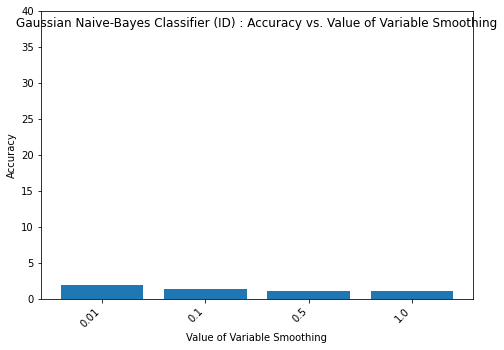

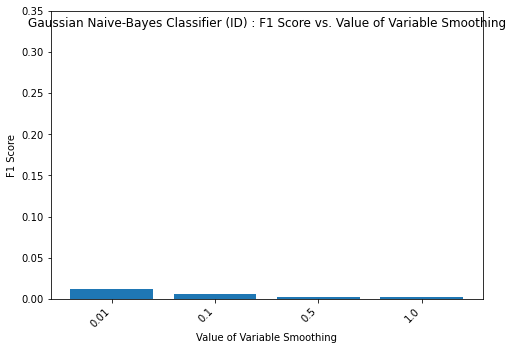

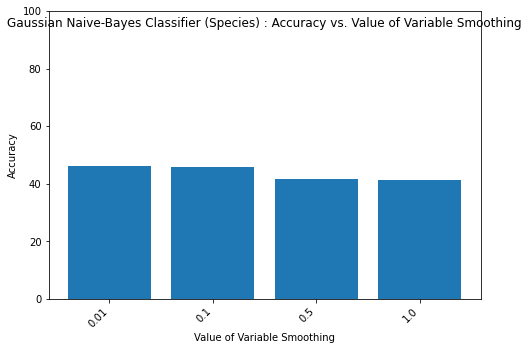

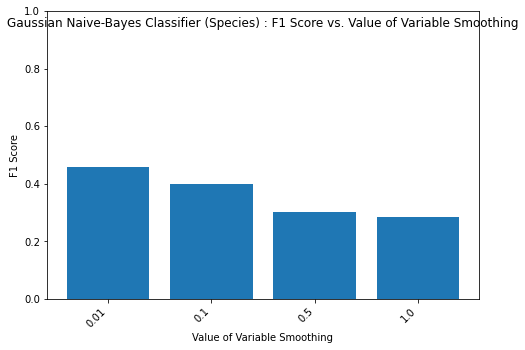

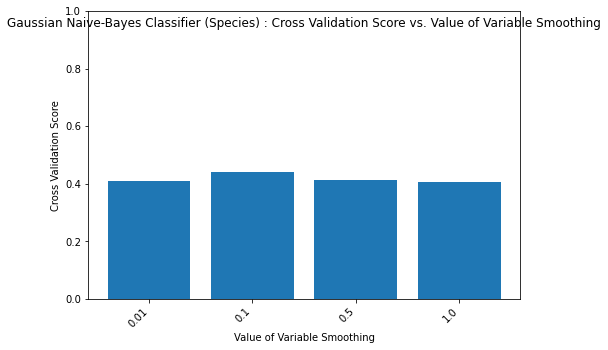

In [71]:
# Gaussian Naive-Bayes
var_smoothing_list = [0.01, 0.1, 0.5, 1.0]
gb_acc = list()
gb_f1_list = list()
gb_species_acc = list()
gb_species_f1_list = list()
gb_species_cvs_list = list()

for i in tqdm(range(len(var_smoothing_list))):
    gbmodel = GaussianNB(var_smoothing=var_smoothing_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    gb_f1_list.append(f1)
    gb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    gb_species_cvs_list.append(np.mean(cross_val_score(gbmodel, test_features_pca, test_labels, cv=5)))
    gb_species_f1_list.append(f1)
    gb_species_acc.append(ac)


plot_scores(var_smoothing_list, gb_acc, gb_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (ID)", True)
plot_scores(var_smoothing_list, gb_species_acc, gb_species_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (Species)", False)
plot_score(var_smoothing_list, gb_species_cvs_list, "Variable Smoothing", "Cross Validation Score", "Gaussian Naive-Bayes Classifier (Species)")

In [72]:
print_best_parameters(var_smoothing_list, gb_acc, gb_f1_list, gb_species_acc, gb_species_f1_list, gb_species_cvs_list)

ID Prediction:
Best Accuracy: 1.925925925925926
Best Accuracy Parameter: 0.01

Best F1 Score : 0.011966837689059913
Best F1 Score  Parameter: 0.01


Species Prediction:
Best Accuracy: 46.0
Best Accuracy Parameter: 0.01

Best F1 Score : 0.4578234139292812
Best F1 Score : 0.01

Best Cross Validation Score: 0.43925925925925924
Best Cross Validation Parameter: 0.1




100%|██████████| 4/4 [04:03<00:00, 60.93s/it]


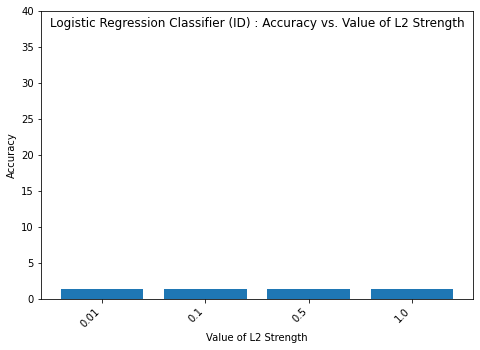

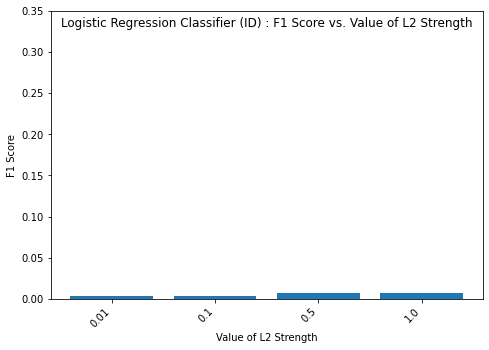

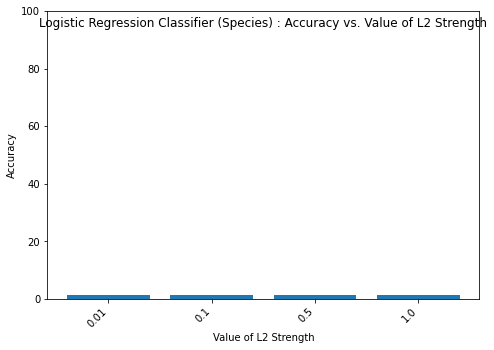

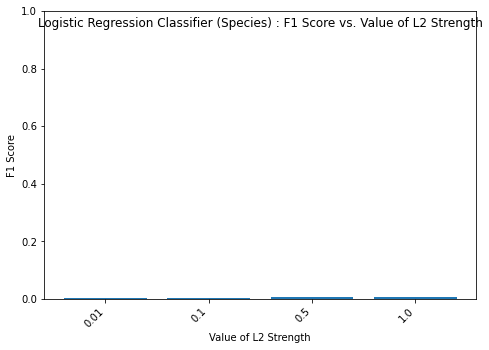

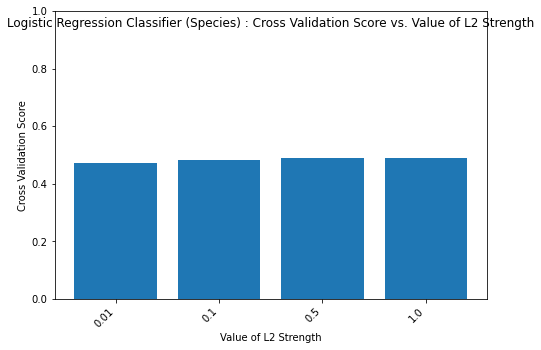

In [73]:
# LogisticRegression
c_list = [0.01, 0.1, 0.5, 1.0]
lr_acc = list()
lr_f1_list = list()
lr_species_acc = list()
lr_species_f1_list = list()
lr_species_cvs_list = list()
    
for i in tqdm(range(len(c_list))):
    lrmodel = LogisticRegression(C=c_list[i], solver="liblinear", multi_class="auto")
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    lr_f1_list.append(f1)
    lr_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    lr_species_cvs_list.append(np.mean(cross_val_score(lrmodel, test_features_pca, test_labels, cv=5)))
    lr_species_f1_list.append(f1)
    lr_species_acc.append(ac)


plot_scores(c_list, lr_acc, lr_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (ID)", True)
plot_scores(c_list, lr_species_acc, lr_species_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (Species)", False)
plot_score(c_list, lr_species_cvs_list, "L2 Strength", "Cross Validation Score", "Logistic Regression Classifier (Species)")

In [74]:
print_best_parameters(c_list, lr_acc, lr_f1_list, lr_species_acc, lr_species_f1_list, lr_species_cvs_list)

ID Prediction:
Best Accuracy: 1.4074074074074074
Best Accuracy Parameter: 0.1

Best F1 Score : 0.0067701886590775485
Best F1 Score  Parameter: 0.5


Species Prediction:
Best Accuracy: 1.4074074074074074
Best Accuracy Parameter: 0.1

Best F1 Score : 0.0067701886590775485
Best F1 Score : 0.5

Best Cross Validation Score: 0.48962962962962964
Best Cross Validation Parameter: 0.5




100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


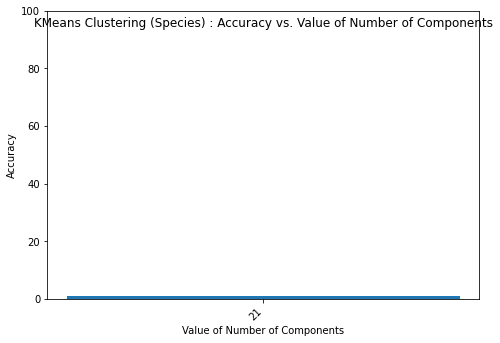

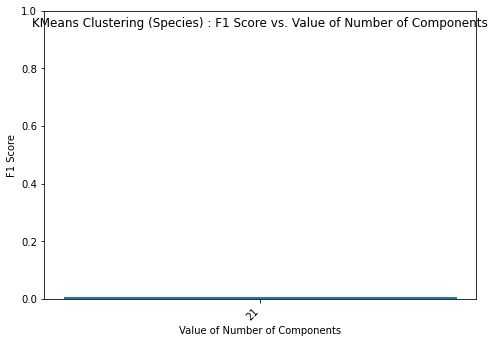

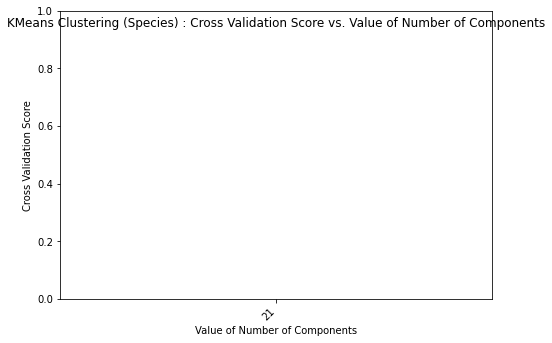

In [76]:
# K-Means clustering
components = [21]
kmeans_species_acc = list()
kmeans_species_f1_list = list()
kmeans_species_cvs_list = list()

# K-Means clustering

for i in tqdm(range(len(components))):
    kmeans = KMeans(components[i], random_state=0)
    # Test IDs
    
    ac,f1,cvs = test_cluster_accuracy(kmeans, train_features_pca, test_features_pca)
    
    kmeans_species_cvs_list.append(cvs)
    kmeans_species_f1_list.append(f1)
    kmeans_species_acc.append(ac)


plot_scores(components, kmeans_species_acc, kmeans_species_f1_list, "Number of Components", "Accuracy", "F1 Score", "KMeans Clustering (Species)", False)
plot_score(components, kmeans_species_cvs_list, "Number of Components", "Cross Validation Score", "KMeans Clustering (Species)")

In [77]:
print("Accuracy:", max(kmeans_species_acc))
print("F1 Score:", max(kmeans_species_f1_list))
print("Cross Validation Score:", max(kmeans_species_cvs_list))

Accuracy: 0.8888888888888888
F1 Score: 0.006411583315017949
Cross Validation Score: -3962567.5736686727


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


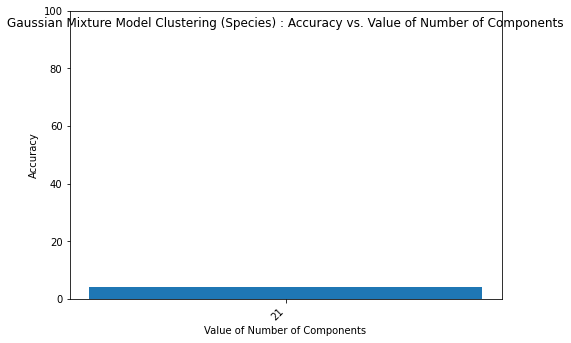

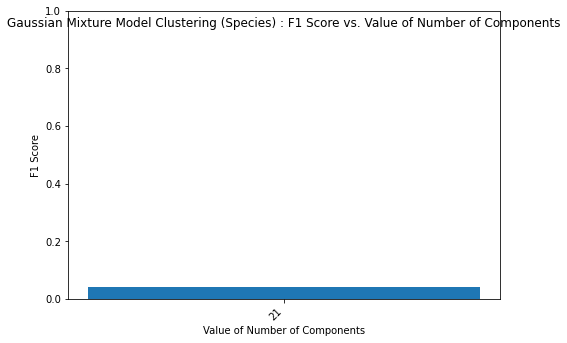

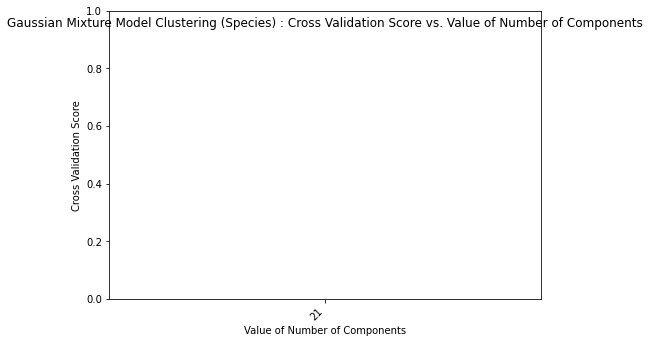

In [78]:
# Gaussian Mixture Model clustering

gmm_acc = list()
gmm_f1_list = list()
gmm_species_acc = list()
gmm_species_f1_list = list()
gmm_species_cvs_list = list()


for i in tqdm(range(len(components))):
    gmm = GMM(n_components=components[i], random_state=0)
    # Test IDs
    
    ac,f1,cvs = test_cluster_accuracy(gmm, train_features_pca, test_features_pca)
    
    gmm_species_cvs_list.append(cvs)
    gmm_species_f1_list.append(f1)
    gmm_species_acc.append(ac)


plot_scores(components, gmm_species_acc, gmm_species_f1_list, "Number of Components", "Accuracy", "F1 Score", "Gaussian Mixture Model Clustering (Species)", False)
plot_score(components, gmm_species_cvs_list, "Number of Components", "Cross Validation Score", "Gaussian Mixture Model Clustering (Species)")

In [79]:
print("Accuracy:", max(gmm_species_acc))
print("F1 Score:", max(gmm_species_f1_list))
print("Cross Validation Score:", max(gmm_species_cvs_list))

Accuracy: 4.0
F1 Score: 0.04172609402856341
Cross Validation Score: -96.81954762337483


In [82]:
# Neural Network

def create_nn(input_dims, output_dims):
    model = Sequential()
    
    # Input layer
    model.add(Dense(200, input_dim=input_dims, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(1024, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(512, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(100, activation='relu'))
    
    # Output layer
    model.add(Dense(output_dims, activation='sigmoid'))

    # Compile the model and calculate its accuracy:
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])     
    
    return model

def test_neural_network(model, training_features, training_labels, testing_features, testing_labels):
    
    # Convert labels to integers
    le = LabelEncoder()
    train_labels_encoded = le.fit_transform(training_labels)
    test_labels_encoded = le.transform(testing_labels)
    
    # Convert train and test labels to one-hot
    enc = OneHotEncoder(handle_unknown='ignore')
    train_labels_onehot = enc.fit_transform(train_labels_encoded.reshape(-1,1)).toarray()
  
    # Fit model
    model.fit(train_features_std, train_labels_onehot, batch_size=32, epochs=40)

    # Predict test labels
    y_predict = model.predict(testing_features)
    
    # Convert prediction output to integer labels
    y_pred_label = list()
    
    # Get index of largest value per row (the predicted label)
    for i in range(y_predict.shape[0]):
        row = y_predict[i]
        y_pred_label.append(np.where(row == np.amax(row))[0][0])
        
    y_pred_label = np.array(y_pred_label)
        
    accuracy = accuracy_score(test_labels_encoded, y_pred_label)*100
    f1 = f1_score(test_labels_encoded, y_pred_label, average="weighted")
    
    return accuracy, f1, cvs

model = create_nn(train_features_std.shape[1], 21) #21 possble species

nn_acc,nn_f1,nn_cvs = test_neural_network(model, train_features_std, train_labels, test_features_std, test_labels)

print("Accuracy: " + str(nn_acc))
print("F1 Score: " + str(nn_f1))

Epoch 1/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0883 - accuracy: 0.2991
Epoch 2/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0448 - accuracy: 0.4107
Epoch 3/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0396 - accuracy: 0.4206
Epoch 4/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0373 - accuracy: 0.4306
Epoch 5/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0359 - accuracy: 0.4443
Epoch 6/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0348 - accuracy: 0.4585
Epoch 7/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0339 - accuracy: 0.4694
Epoch 8/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0333 - accuracy: 0.4776
Epoch 9/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.0328 - accuracy: 0.4854
Epoch 10/40
5400/5400 [==============================] - 16s 3ms/step - l

In [28]:
model_id = create_nn(train_features_std.shape[1], 1350) #1350 individuals

id_nn_acc, id_nn_f1 = test_neural_network(model_id, train_features_std, train_ids, test_features_std, test_ids)

print("Accuracy: " + str(id_nn_acc))
print("F1 Score: " + str(id_nn_f1))

Epoch 1/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.2497 - accuracy: 5.5556e-04
Epoch 2/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2483 - accuracy: 1.8519e-04
Epoch 3/40
5400/5400 [==============================] - 16s 3ms/step - loss: 0.2466 - accuracy: 3.7037e-04
Epoch 4/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2443 - accuracy: 1.8519e-04
Epoch 5/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2407 - accuracy: 3.7037e-04
Epoch 6/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2352 - accuracy: 5.5556e-04
Epoch 7/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2262 - accuracy: 9.2593e-04
Epoch 8/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.2113 - accuracy: 7.4074e-04
Epoch 9/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.1869 - accuracy: 7.4074e-04
Epoch 10/40
5400/5400 [==============

In [29]:
# Hybrid Model


def create_nn2(input_dims, output_dims):
    model = Sequential()
    
    # Input layer
    model.add(Dense(200, input_dim=input_dims, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(5000, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(2000, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(1500, activation='relu'))
    
    # Output layer
    model.add(Dense(output_dims, activation='sigmoid'))

    # Compile the model and calculate its accuracy:
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])     
    
    return model


class Two_Layer_Random_Forest_Model:
    
    def __init__(self):
        self.id_classifiers = list()
        self.species_feature_data = list()
        self.species_id_data = list()
        
        # Create classifer for species
        self.species_classifier = RandomForestClassifier(random_state=42,
                                                       n_jobs=-1,
                                                       max_depth=None,
                                                       n_estimators=100,
                                                       oob_score=True)
    
    def fit(self, training_features, training_labels, training_ids):
        # Convert labels to integers
        self.le = LabelEncoder()
        train_labels_encoded = self.le.fit_transform(training_labels)
        train_ids_encoded = self.le.fit_transform(training_ids)
        
        # Fit species classfier with training features and species labels
        self.species_classifier.fit(training_features, train_labels_encoded)
        
        for i in range(21):
            self.id_classifiers.append(RandomForestClassifier(random_state=42,
                                                         n_jobs=-1,
                                                         max_depth=None,
                                                         n_estimators=100,
                                                         oob_score=True))
            self.species_feature_data.append(list())
            self.species_id_data.append(list())
            
        # Append training data for each species in its designated bin
        for i in range(train_labels_encoded.shape[0]):
            label = train_labels_encoded[i]
            self.species_feature_data[label].append(training_features[i,:])
            self.species_id_data[label].append(train_ids_encoded[i])
    
        # Convert all combined training data per predicted species and fit each classfier
        for i in tqdm(range(21)):
            self.species_feature_data[i] = np.array(self.species_feature_data[i])
            self.species_id_data[i] = np.array(self.species_id_data[i])
            self.id_classifiers[i].fit(self.species_feature_data[i], self.species_id_data[i])
            
    def get_accuracy_f1(self, testing_features, testing_labels):
        
        # Convert labels to integers
        test_labels_encoded = self.le.transform(testing_labels)
        
        id_pred = list()
        for i in tqdm(range(testing_features.shape[0])):
            feature_row = testing_features[i,:].reshape(1, -1)
        
            # Predict the species
            species_pred = self.species_classifier.predict(feature_row)[0]
            
            # Predict the ID based on the predicted species model
            id_prediction = self.id_classifiers[species_pred].predict(feature_row)[0]
        
            id_pred.append(id_prediction)
        
        # Convert output to array
        id_pred = np.array(id_pred)
    
        # Compute Results
        accuracy = accuracy_score(test_labels_encoded, id_pred)*100
        f1 = f1_score(test_labels_encoded, id_pred, average="weighted")
            
        return accuracy, f1 
    
class Neural_Network_Random_Forest_Model:
    
    def __init__(self):
        self.id_classifiers = list()
        self.species_feature_data = list()
        self.species_id_data = list()
    
    def fit(self, training_features, training_labels, training_ids):
        
        # Create classifer for species
        self.species_classifier = create_nn2(training_features.shape[1], 21)
        
        # Convert labels to integers
        self.le = LabelEncoder()
        train_labels_encoded = self.le.fit_transform(training_labels)
        train_ids_encoded = self.le.fit_transform(training_ids)
        
        # Convert train and test labels to one-hot
        self.enc = OneHotEncoder(handle_unknown='ignore')
        train_labels_onehot = self.enc.fit_transform(train_labels_encoded.reshape(-1,1)).toarray() 
            
        # Fit species classfier with training features and species labels
        self.species_classifier.fit(training_features, train_labels_onehot, batch_size=32, epochs=25)
        
        for i in range(21):
            self.id_classifiers.append(RandomForestClassifier(random_state=42,
                                                         n_jobs=-1,
                                                         max_depth=None,
                                                         n_estimators=100,
                                                         oob_score=True))
            self.species_feature_data.append(list())
            self.species_id_data.append(list())
            
        # Append training data for each species in its designated bin
        for i in range(train_labels_encoded.shape[0]):
            label = train_labels_encoded[i]
            self.species_feature_data[label].append(train_features_pca[i,:])
            self.species_id_data[label].append(train_ids_encoded[i])
    
        # Convert all combined training data per predicted species and fit each classfier
        for i in tqdm(range(21)):
            self.species_feature_data[i] = np.array(self.species_feature_data[i])
            self.species_id_data[i] = np.array(self.species_id_data[i])
            self.id_classifiers[i].fit(self.species_feature_data[i], self.species_id_data[i])
            
    def get_accuracy_f1(self, testing_features, testing_labels):
        
        # Convert labels to integers
        test_labels_encoded = self.le.transform(testing_labels)
        
        id_pred = list()
        for i in tqdm(range(testing_features.shape[0])):
            feature_row = testing_features[i,:].reshape(1, -1)
            pca_row = test_features_pca[i,:].reshape(1, -1)
        
            # Predict the species
            species_pred = self.species_classifier.predict(feature_row)[0]
            species_pred = np.where(species_pred == np.amax(species_pred))[0][0]
            
            # Predict the ID based on the predicted species model
            id_prediction = self.id_classifiers[species_pred].predict(pca_row)[0]
        
            id_pred.append(id_prediction)
        
        # Convert output to array
        id_pred = np.array(id_pred)
    
        # Compute Results
        accuracy = accuracy_score(test_labels_encoded, id_pred)*100
        f1 = f1_score(test_labels_encoded, id_pred, average="weighted")
            
        return accuracy, f1


In [30]:
nn_rf_model = Neural_Network_Random_Forest_Model()
nn_rf_model.fit(train_features_std, train_labels, train_ids)
nn_rf_acc, nn_rf_f1 = nn_rf_model.get_accuracy_f1(test_features_std, test_ids)

print("Accuracy: " + str(nn_rf_acc))
print("F1 Score: " + str(nn_rf_f1))

Epoch 1/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.1033 - accuracy: 0.3011
Epoch 2/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0451 - accuracy: 0.3996
Epoch 3/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0397 - accuracy: 0.4135
Epoch 4/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0376 - accuracy: 0.4261
Epoch 5/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0363 - accuracy: 0.4367
Epoch 6/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0353 - accuracy: 0.4443
Epoch 7/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0346 - accuracy: 0.4480
Epoch 8/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0341 - accuracy: 0.4517
Epoch 9/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0337 - accuracy: 0.4574
Epoch 10/25
5400/5400 [==============================] - 22s 4ms/step - l

100%|██████████| 1350/1350 [02:47<00:00,  8.07it/s]

Accuracy: 1.2592592592592593
F1 Score: 0.007580246913580247


In [31]:
hybrid_model_1 = Two_Layer_Random_Forest_Model()
hybrid_model_1.fit(train_features_pca, train_labels, train_ids)
hybrid_acc, hybrid_f1 = hybrid_model_1.get_accuracy_f1(test_features_pca, test_ids)

print("Accuracy: " + str(hybrid_acc))
print("F1 Score: " + str(hybrid_f1))

100%|██████████| 1350/1350 [04:52<00:00,  4.61it/s]

Accuracy: 1.925925925925926
F1 Score: 0.014419753086419754


In [32]:
# Prepare compilation

result_labels_id = ["kNN", "BernoulliNB", "Decision Tree", "Random Forest", "GaussianNB",
                    "Logistic Regression", "Neural Network", "Two-Layer Random Forest", "Neural Network to Random Forest"]
result_labels_species = ["kNN", "BernoulliNB", "Decision Tree", "Random Forest", "GaussianNB",
                         "Logistic Regression", "K-Means", "Gaussian Mixture Model", "Neural Network"]


id_accuracies = list()
id_accuracies.append(max(knn_acc))
id_accuracies.append(max(nb_acc))
id_accuracies.append(max(dt_acc))
id_accuracies.append(max(rf_acc))
id_accuracies.append(max(gb_acc))
id_accuracies.append(max(lr_acc))
id_accuracies.append(id_nn_acc)
id_accuracies.append(hybrid_acc)
id_accuracies.append(nn_rf_acc)

id_f1s = list()
id_f1s.append(max(knn_f1_list))
id_f1s.append(max(nb_f1_list))
id_f1s.append(max(dt_f1_list))
id_f1s.append(max(rf_f1_list))
id_f1s.append(max(gb_f1_list))
id_f1s.append(max(lr_f1_list))
id_f1s.append(id_nn_f1)
id_f1s.append(hybrid_f1)
id_f1s.append(nn_rf_f1)


id_species_accuracies = list()
id_species_accuracies.append(max(knn_species_acc))
id_species_accuracies.append(max(nb_species_acc))
id_species_accuracies.append(max(dt_species_acc))
id_species_accuracies.append(max(rf_species_acc))
id_species_accuracies.append(max(gb_species_acc))
id_species_accuracies.append(max(lr_species_acc))
id_species_accuracies.append(max(kmeans_species_acc))
id_species_accuracies.append(max(gmm_species_acc))
id_species_accuracies.append(nn_acc)

id_species_f1s = list()
id_species_f1s.append(max(knn_species_f1_list))
id_species_f1s.append(max(nb_species_f1_list))
id_species_f1s.append(max(dt_species_f1_list))
id_species_f1s.append(max(rf_species_f1_list))
id_species_f1s.append(max(gb_species_f1_list))
id_species_f1s.append(max(lr_species_f1_list))
id_species_f1s.append(max(kmeans_species_f1_list))
id_species_f1s.append(max(gmm_species_f1_list))
id_species_f1s.append(nn_f1)


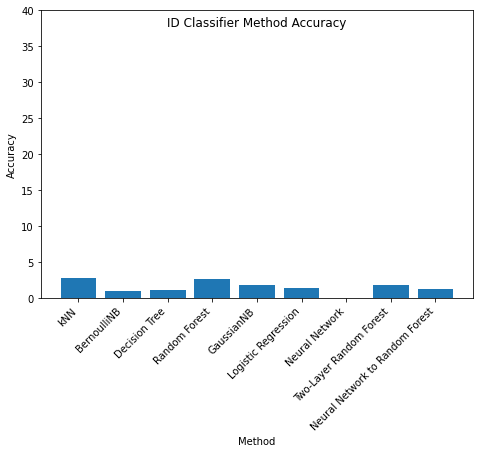

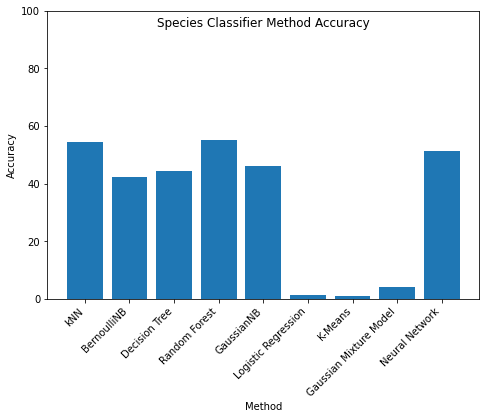

In [33]:
# Plot Accuracies
fig = plt.figure()
fig.suptitle("ID Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,40)
ax.bar(result_labels_id, id_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,100)
ax.bar(result_labels_species, id_species_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

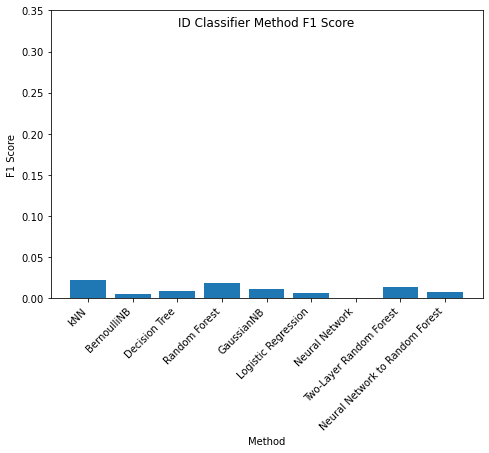

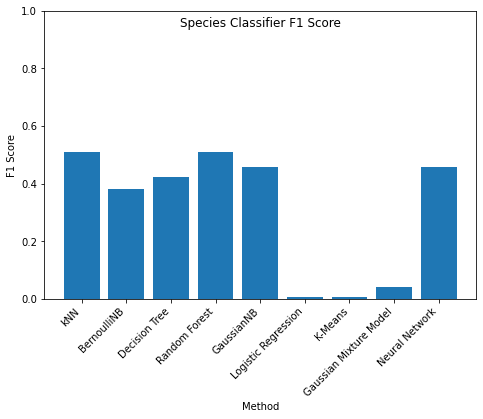

In [34]:
# Plot F1 scores
fig = plt.figure()
fig.suptitle("ID Classifier Method F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,0.35)
ax.bar(result_labels_id, id_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,1)
ax.bar(result_labels_species, id_species_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()